## Part 2: Calculate UBI Model 

**Load Dataset from Part 1 Notebook**

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

%matplotlib inline

In [2]:
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

In [3]:
df = pd.read_csv("part_1_df.csv")
poverty_rates = pd.read_csv("poverty_rates.csv")
gini_index = pd.read_csv("gini_index.csv")

df.head()


,Unnamed: 0,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,STATEFIP,HHINCOME,PERNUM,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,POPSTAT,FAMSIZE,FTOTVAL,INCTOT,INCWAGE,ADJGINC,FEDTAX,FEDTAXAC,FILESTAT,MARGTAX,TAXINC,RACE_CAT,THRESH,POV_PRE_TAX,RACE_POV,RACE_POP,AGE_GROUP,AGE_POV_GROUP,POST_TAX_INC_IN,FEDTAXAC_HH,POST_TAX_INC_HH,POV_POST_TAX,POST_RACE_POV,POST_AGE_GROUP_POV
0,0,4,3,20180302857800,1,2031.67,23,18000,1,20180302857801,2031.67,21,1,100,6,1,1,18000,18000,18000,18000,600,600,5,10,6000,White,12490.0,0,7.316044,78239,20,9.178082,17400,600,17400,0,6.483979,8.295282
1,1,6,3,20190302835500,1,1232.04,23,21780,1,20190302835501,1232.04,85,2,100,5,1,1,21780,21780,0,18000,440,440,5,10,4400,White,12490.0,0,7.316044,78239,85,13.695198,21340,440,21340,0,6.483979,13.653445
2,2,7,3,20190302846800,1,1209.17,23,12000,1,20190302846801,1209.17,61,2,100,6,1,1,12000,12000,12000,12000,0,-250,5,0,0,White,12490.0,1,7.316044,78239,60,8.940518,12250,-250,12250,1,6.483979,8.879698
3,3,8,3,20190302822300,1,1146.23,23,22727,1,20190302822301,1146.23,73,2,100,4,1,2,22727,10727,0,0,0,0,6,0,0,White,16910.0,0,7.316044,78239,70,7.678913,10727,-250,22977,0,6.483979,7.661501
4,4,8,3,20190302822300,1,1146.23,23,22727,2,20190302822302,1480.79,37,1,100,6,1,2,22727,12000,12000,12000,0,-250,5,0,0,White,16910.0,0,7.316044,78239,35,8.708592,12250,-250,22977,0,6.483979,6.444099



Note: I do not need to load in the previous household (hh) dataset, since I am about to generate new variables, I will simply subset the main dataframe down to the households (CPSID's as opposed to CPSIDP's). 

## Classic UBI: 15% Flat Tax

There are many different proposed forms for a UBI. Unfortunately, it is outside the scope of this project to model all of them. What these programs (in their classic form) usually have in common is that each individual in a UBI system receives the same distribution, regardless of their income. There are two main approaches such a structure can take:

1) Decide up-front how much money will be distributed on an annual/monthly basis, and calculate the funds necesary to generate this amount (Ghatak & Maniquet, 2019).
2) Decide what flat tax rate can be used, and then divide this amount evenly across the individuals who receive the program (Ghatak & Maniquet, 2019). 

I have chosen option 2, since one of the main purposes of a UBI is to remove welfare cliffs and high marginal tax rates for the poor (along with stigma) that come from dealing with bulky and inefficient (not to mention administratively expensive) means-tested welfare systems. Such systems can result in forcing people to remain in low-paying work (lest they lose disability benefits by getting a higher paying job, for example), and cause massive wastes of resources in determining complex eligibility requirements. A flat-tax removes the need for a bulky means-testing system by simply charging everyone the same amount and sending out a fat check. Option 1 does not clearly delineate the manner in which funds will be raised, and since my goal is to model a completely non-means-tested welfare system, I choose option 2. 

I have set 15% as the rate since it cuts at the lower-middle end of the existing tax rates, meaning that it is not too cumbersome of a change for individual taxpayers. 

For the purpose of generating this UBI, I am treating the entire sample as a single nation or UBI unit. I apply this 15% rate to every individual's pre-tax income. I choose to use pre-tax income, and not CPS-calculated taxable income, since taxable income already incorproates many of the complex benefit structures a UBI is intended to replace. 

It also important that the UBI is setup to deliver benefits to each individual citizen (that is the way a classic UBI is structered), as opposed to each household. This method gives each citizen the maximum amount of individual latittude and freedom to determine their own financial future without necessarily needing to rely on their household's splitting of government benefits. The results of a UBI would also be extremely different if households were the main recipients as opposed to individuals. 

I also apply the UBI only to adults, to fit with the most standard definitions. To classifiy as a child, the individual must also not be part of a one-person household (i.e., they live with other family who are presumably their primary breadwinners). If someone under the age of 18 is their own househould (like an emancipated minor), they are also classified as an adult in oder to receive the benefit (otherwise they will not receive anything). All other individuals are classified as an adult. Of course, there is an argument to be made for children to receive some benefits (otherwise children with one adult guardian are at a disadvantage) but that is outside the scope of this standard UBI. 

Under such a structure, the distribution of the UBI will take the following form: 

**Federal Revenues = (UBI)*(A)**

where A = the number of adults and UBI = the amount of the income distribution. 

In [4]:
#classify who is a child and who is an adult 

def adult_child(row): 
    'write a function that defines someone as poor if their income is less than than the threshold for their family size'
    if row['AGE'] < 18 and row['FAMSIZE'] > 1: 
        val = "C"
    elif row['AGE'] < 18 and row['FAMSIZE'] == 1: 
        val = "A"
    elif row['AGE'] >= 18: 
        val = "A" #for independent minor 
    else: 
        val = "NaN" 
    return val 

#create new column using the function above
df['ADULT_CHILD'] = df.apply(adult_child, axis=1)

In [5]:
#check to see that the function accuruately classified the tricky case of being under 18 in a single person household:  

df[["AGE", "ADULT_CHILD", "FAMSIZE"]].groupby("FAMSIZE").get_group(1).sort_values(by = "AGE").head(100)

#it did.

,AGE,ADULT_CHILD,FAMSIZE
31210,15,A,1
16799,15,A,1
70910,15,A,1
44577,15,A,1
64723,15,A,1
1623,15,A,1
93494,15,A,1
78452,15,A,1
62345,15,A,1
92420,15,A,1


In [6]:
#3) Create function to assign variable that takes 15% of all adults' individual income: 

def flat_tax(row): 
    'write a function that defines someone as poor if their income is less than than the threshold for their family size'
    if row['ADULT_CHILD'] == "C": 
        val = 0
    elif row['ADULT_CHILD'] == "A": 
        val = (row["INCTOT"]*.15)
    else: 
        val = "NaN" 
    return val 

#create new column 'Good' using the function above
df['FLAT_TAX'] = df.apply(flat_tax, axis=1)

#check that the function works correctly 
df[["AGE", "ADULT_CHILD", "FAMSIZE", "INCTOT", "FEDTAX", "FLAT_TAX"]].sort_values(by = "AGE").head(25)


,AGE,ADULT_CHILD,FAMSIZE,INCTOT,FEDTAX,FLAT_TAX
81756,15,C,10,48000,4130,0.0
6226,15,C,8,0,0,0.0
74949,15,C,6,0,0,0.0
69531,15,C,5,0,0,0.0
29358,15,C,4,0,0,0.0
8304,15,C,3,0,0,0.0
29371,15,C,3,48000,4130,0.0
25476,15,C,5,0,0,0.0
58011,15,C,3,0,0,0.0
25446,15,C,4,0,0,0.0


In [7]:
#4) total federal flat tax revenues: 
ubi_rev = sum(df["FLAT_TAX"])
ubi_rev

653141966.6999196

In [8]:
#5) divide over the number of adults in the sample 
n = df.groupby("ADULT_CHILD").get_group("A")["CPSIDP"].count()
n

92106

In [9]:
#6) amount of ubi distribution everyone receives: 
ubi = ubi_rev/n
ubi



7091.198908864999

In [10]:
#assign ubi distribution to a variable: 
def ubi_dist(row): 
    'write a function that calculates the amount of UBI distribution each individual receives'
    if row['ADULT_CHILD'] == "C": 
        val = 0
    elif row['ADULT_CHILD'] == "A": 
        val = ubi
    else: 
        val = "NaN" 
    return val 

#create new column 'Good' using the function above
df['UBI_DIST'] = df.apply(ubi_dist, axis=1) #individual 

In [11]:
#check that function applied the UBI correctly: 
df.groupby("ADULT_CHILD").get_group("C")["UBI_DIST"].sum()

#it did - the children did not receive a UBI distribution. 

0.0

Thus, the total federal revenues of 653,141,966.7 under this tax structure provide each self-sufficient adult with $7,091 as their ubi distribution. This money could be delivered all at once or over the course of a single year (other research studies the impact of redistribution timing on poverty and other measures of wellbeing). Compare this result to the baseline collected amount of 456,179,028.

**Post-UBI Income Distribution**

Post-UBI Individual Income:

In [12]:
#define Post-UBI individual income 
df["POST_UBI_INC"] = df["INCTOT"]+ df["UBI_DIST"]



In [13]:
#Calculate change in Post-NUBI Individual Income 
def ubi_ind_change(row): 
    'write a function that calculates the amount of UBI distribution each individual receives'
    try:
        val = ((row["POST_UBI_INC"] - row["INCTOT"])/row["INCTOT"])*100
    except ZeroDivisionError:
        val = ((row["POST_UBI_INC"] - 1)/1)*100 
    return val 

df["UBI_INCTOT_CHANGE"] = df.apply(ubi_ind_change, axis=1)
#Households that originally had 0 income end up dividing by 0, leaving inf. Need to replace this value to get accurate summary data. 

In the above function, I define the percent change in income due to the UBI. Unfortunately, this task is made complex by the fact that some starting incomes are 0, which means that the percent change is technically not mathematically possible to calculate, unless one is willing to receive an infinite, undefined, or otherwise empty value (division by 0 is not possible). However, reporting every individual who received a UBI distribution after starting with a $0 income as UND would severely undercount the amount of people who benefitted from the NUBI. The difference between these two incomes is indeed an amount that is worth knowing. In this case, since having a $0 is essentially the same pragmatically as having $1.00 in income (without demonstrating a one-million percent increase, for example), in cases that the function above raises a ZeroDivisionError, I have simply used 1 in place of 0. This allows me to provide a better understanding of the dramatic impact such a policy would have on literally the poorest individuals in my sample (besides those who are in debt). 

In [14]:
#check my results
df[["AGE", "ADULT_CHILD", "FAMSIZE", "INCTOT", "FEDTAX", "FLAT_TAX", "UBI_DIST", "POST_UBI_INC", "UBI_INCTOT_CHANGE"]]

,AGE,ADULT_CHILD,FAMSIZE,INCTOT,FEDTAX,FLAT_TAX,UBI_DIST,POST_UBI_INC,UBI_INCTOT_CHANGE
0,21,A,1,18000,600,2700.00,7091.198909,25091.198909,39.395549
1,85,A,1,21780,440,3267.00,7091.198909,28871.198909,32.558305
2,61,A,1,12000,0,1800.00,7091.198909,19091.198909,59.093324
3,73,A,2,10727,0,1609.05,7091.198909,17818.198909,66.106077
4,37,A,2,12000,0,1800.00,7091.198909,19091.198909,59.093324
...,...,...,...,...,...,...,...,...,...
96568,41,A,5,100200,0,15030.00,7091.198909,107291.198909,7.077045
96569,71,A,3,65671,3221,9850.65,7091.198909,72762.198909,10.798068
96570,49,A,3,23660,1209,3549.00,7091.198909,30751.198909,29.971255
96571,36,A,3,0,8199,0.00,7091.198909,7091.198909,709019.890886


Note the extremely large percent changes for those with initially 0 income who receive a distribution. 

Post-UBI Household Income: 

To calculate this value, I group the data by household (CPSID) and then add up the post-UBI income from all the family togethers into one for the whole household. 

In [15]:
#define Post-UBI Household income (this is necessary to classify households into poverty thresholds, which are defined by household income.)

post_ubi_hh = df.groupby(['CPSID'])['POST_UBI_INC'].sum().to_frame().rename(columns={"POST_UBI_INC": "POST_UBI_HH"}).reset_index()
df = df.merge(post_ubi_hh, how = "left", on = "CPSID")
df.head()


,Unnamed: 0,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,STATEFIP,HHINCOME,PERNUM,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,POPSTAT,FAMSIZE,FTOTVAL,INCTOT,INCWAGE,ADJGINC,FEDTAX,FEDTAXAC,FILESTAT,MARGTAX,TAXINC,RACE_CAT,THRESH,POV_PRE_TAX,RACE_POV,RACE_POP,AGE_GROUP,AGE_POV_GROUP,POST_TAX_INC_IN,FEDTAXAC_HH,POST_TAX_INC_HH,POV_POST_TAX,POST_RACE_POV,POST_AGE_GROUP_POV,ADULT_CHILD,FLAT_TAX,UBI_DIST,POST_UBI_INC,UBI_INCTOT_CHANGE,POST_UBI_HH
0,0,4,3,20180302857800,1,2031.67,23,18000,1,20180302857801,2031.67,21,1,100,6,1,1,18000,18000,18000,18000,600,600,5,10,6000,White,12490.0,0,7.316044,78239,20,9.178082,17400,600,17400,0,6.483979,8.295282,A,2700.00,7091.198909,25091.198909,39.395549,25091.198909
1,1,6,3,20190302835500,1,1232.04,23,21780,1,20190302835501,1232.04,85,2,100,5,1,1,21780,21780,0,18000,440,440,5,10,4400,White,12490.0,0,7.316044,78239,85,13.695198,21340,440,21340,0,6.483979,13.653445,A,3267.00,7091.198909,28871.198909,32.558305,28871.198909
2,2,7,3,20190302846800,1,1209.17,23,12000,1,20190302846801,1209.17,61,2,100,6,1,1,12000,12000,12000,12000,0,-250,5,0,0,White,12490.0,1,7.316044,78239,60,8.940518,12250,-250,12250,1,6.483979,8.879698,A,1800.00,7091.198909,19091.198909,59.093324,19091.198909
3,3,8,3,20190302822300,1,1146.23,23,22727,1,20190302822301,1146.23,73,2,100,4,1,2,22727,10727,0,0,0,0,6,0,0,White,16910.0,0,7.316044,78239,70,7.678913,10727,-250,22977,0,6.483979,7.661501,A,1609.05,7091.198909,17818.198909,66.106077,36909.397818
4,4,8,3,20190302822300,1,1146.23,23,22727,2,20190302822302,1480.79,37,1,100,6,1,2,22727,12000,12000,12000,0,-250,5,0,0,White,16910.0,0,7.316044,78239,35,8.708592,12250,-250,22977,0,6.483979,6.444099,A,1800.00,7091.198909,19091.198909,59.093324,36909.397818


In [16]:
#Calculate change in Post-NUBI Individual Income 
def ubi_hh_change(row): 
    'write a function that calculates the amount of UBI distribution each individual receives'
    try:
        val = ((row["POST_UBI_HH"] - row["HHINCOME"])/row["HHINCOME"])*100
    except ZeroDivisionError:
        val = ((row["HHINCOME"] - 1)/1)*100 
    return val 

In [17]:
#create new column 'Good' using the function above
df['UBI_HH_CHANGE'] = df.apply(ubi_hh_change, axis=1)
df.head()

,Unnamed: 0,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,STATEFIP,HHINCOME,PERNUM,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,POPSTAT,FAMSIZE,FTOTVAL,INCTOT,INCWAGE,ADJGINC,FEDTAX,FEDTAXAC,FILESTAT,MARGTAX,TAXINC,RACE_CAT,THRESH,POV_PRE_TAX,RACE_POV,RACE_POP,AGE_GROUP,AGE_POV_GROUP,POST_TAX_INC_IN,FEDTAXAC_HH,POST_TAX_INC_HH,POV_POST_TAX,POST_RACE_POV,POST_AGE_GROUP_POV,ADULT_CHILD,FLAT_TAX,UBI_DIST,POST_UBI_INC,UBI_INCTOT_CHANGE,POST_UBI_HH,UBI_HH_CHANGE
0,0,4,3,20180302857800,1,2031.67,23,18000,1,20180302857801,2031.67,21,1,100,6,1,1,18000,18000,18000,18000,600,600,5,10,6000,White,12490.0,0,7.316044,78239,20,9.178082,17400,600,17400,0,6.483979,8.295282,A,2700.00,7091.198909,25091.198909,39.395549,25091.198909,39.395549
1,1,6,3,20190302835500,1,1232.04,23,21780,1,20190302835501,1232.04,85,2,100,5,1,1,21780,21780,0,18000,440,440,5,10,4400,White,12490.0,0,7.316044,78239,85,13.695198,21340,440,21340,0,6.483979,13.653445,A,3267.00,7091.198909,28871.198909,32.558305,28871.198909,32.558305
2,2,7,3,20190302846800,1,1209.17,23,12000,1,20190302846801,1209.17,61,2,100,6,1,1,12000,12000,12000,12000,0,-250,5,0,0,White,12490.0,1,7.316044,78239,60,8.940518,12250,-250,12250,1,6.483979,8.879698,A,1800.00,7091.198909,19091.198909,59.093324,19091.198909,59.093324
3,3,8,3,20190302822300,1,1146.23,23,22727,1,20190302822301,1146.23,73,2,100,4,1,2,22727,10727,0,0,0,0,6,0,0,White,16910.0,0,7.316044,78239,70,7.678913,10727,-250,22977,0,6.483979,7.661501,A,1609.05,7091.198909,17818.198909,66.106077,36909.397818,62.403299
4,4,8,3,20190302822300,1,1146.23,23,22727,2,20190302822302,1480.79,37,1,100,6,1,2,22727,12000,12000,12000,0,-250,5,0,0,White,16910.0,0,7.316044,78239,35,8.708592,12250,-250,22977,0,6.483979,6.444099,A,1800.00,7091.198909,19091.198909,59.093324,36909.397818,62.403299


In [18]:
#reassign hh to include the new variables just calculated into household data. 
hh = df.drop_duplicates(["CPSID"])

In [19]:
#view changes 
ind_summary = df.agg(
    {
        "INCTOT": ["min", "max", "mean", "median"], 
        "POST_TAX_INC_IN": ["min", "max", "mean", "median"], 
        "POST_UBI_INC": ["min", "max", "mean", "median"],
        "UBI_INCTOT_CHANGE": ["min", "max", "mean", "median"]
    }
)

hh_summary = hh.agg(
    {
        "HHINCOME": ["min", "max", "mean", "median"], 
        "POST_UBI_HH": ["min", "max", "mean", "median"],
        "UBI_HH_CHANGE": ["min", "max", "mean", "median"]
    }
)

ind_summary.round(), hh_summary.round()

(           INCTOT  POST_TAX_INC_IN  POST_UBI_INC  UBI_INCTOT_CHANGE
 min      -13000.0        -365822.0       -5909.0          -709120.0
 max     2055999.0        1422314.0     2063090.0           709120.0
 mean      45183.0          40460.0       51947.0            59113.0
 median    29625.0          28030.0       36703.0               21.0,
          HHINCOME  POST_UBI_HH  UBI_HH_CHANGE
 min      -13000.0      -5909.0        -1894.0
 max     2223800.0    2237982.0      2127360.0
 mean      89268.0     102629.0          820.0
 median    63005.0      76875.0           20.0)

**Classic UBI Income Distribution**

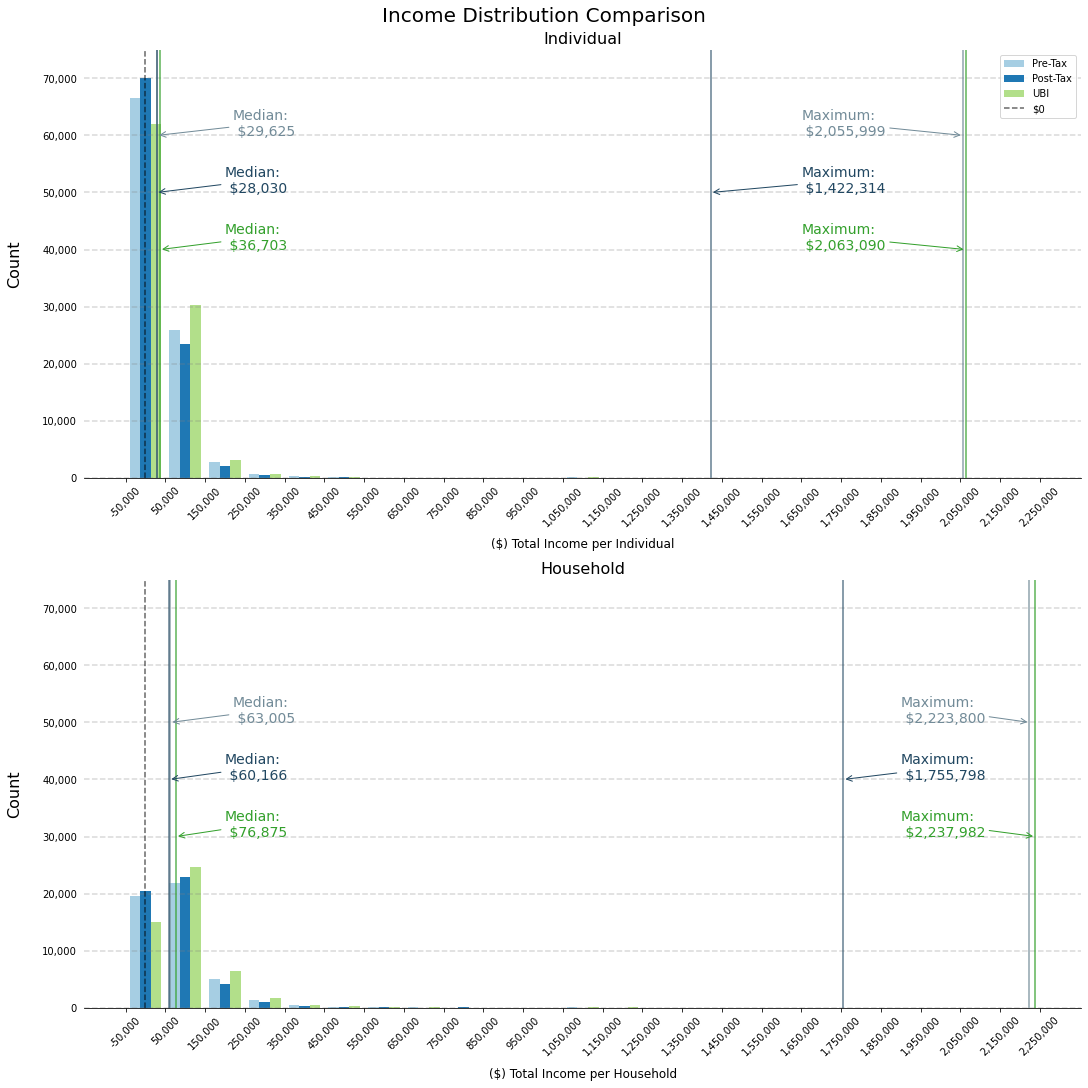

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)

bins = np.arange(-50_000, 2_300_000, 100_000)

#assigning long colors 
pre_tax = (0.44749456473280025, 0.5442189568340771, 0.5952299195805278)
post_tax = (0.13127338987823528, 0.27751527607814364, 0.38095970787350786)
ubi = ('#33a02c')
nubi_main = ("#fb8072")
nubi_label = (0.8238685424331371, 0.4290123592475775, 0.38441179024460176)

axes[0].hist([df['INCTOT'], df['POST_TAX_INC_IN'], df['POST_UBI_INC']], bins, label=['Pre-Tax', 'Post-Tax', "UBI"], color = [("#a6cee3"), ("#1f78b4"), ('#b2df8a')], align = 'mid')
axes[1].hist([hh['HHINCOME'], hh['POST_TAX_INC_HH'], hh['POST_UBI_HH']], bins, label=['Pre-Tax', 'Post-Tax', "UBI"], color = [("#a6cee3"), ("#1f78b4"), ('#b2df8a')], align = 'mid')

# Set title
fig.suptitle("Income Distribution Comparison", size=20) #y=0.93
axes[0].set_title("Individual", size=16) #, y=1
axes[1].set_title("Household", size=16) #y=0.5

#####################################################INDIVIDUAL
#Format x-axis
axes[0].set_xticks(bins)
axes[0].set_xlabel("($) Total Income per Individual", labelpad=10, size=12) 
axes[0].ticklabel_format(useOffset=False, style='plain')
#ax.set_xticks(np.arange(-200_000, 2_500_000, 100_000))
axes[0].set_xticklabels(axes[0].get_xticks(), rotation = 45)
axes[0].tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
axes[0].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Set y-axis label
axes[0].set_ylabel("Count", labelpad=20, size=16)
# Draw horizontal axis lines
vals = axes[0].get_yticks()
for tick in vals:
    axes[0].axhline(y=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)
axes[0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[0].set_ylim(0, 75_000)

#adding other lines
axes[0].axvline(x=0, alpha=0.6, linestyle = "dashed", color='black', zorder=1, label = "$0")

#Pre-Tax
axes[0].axvline(x=max(df['INCTOT']), alpha=0.8, color=pre_tax, zorder=1)
axes[0].axvline(x=(df['INCTOT'].median()), alpha=0.8, color=pre_tax, zorder=1)

#Post-Tax
axes[0].axvline(x=max(df['POST_TAX_INC_IN']), alpha=0.7, color=post_tax, zorder=1)
axes[0].axvline(x=(df['POST_TAX_INC_IN'].median()), alpha=0.7, color=post_tax, zorder=1)

#UBI
axes[0].axvline(x=max(df['POST_UBI_INC']), alpha=0.8, color=ubi, zorder=1)
axes[0].axvline(x=(df['POST_UBI_INC'].median()), alpha=0.8, color=ubi, zorder=1)

#annotations
#Pre-Tax
axes[0].annotate("Maximum:\n $2,055,999", xy=(max(df['INCTOT']), 60000), xytext=(1650000, 60000), arrowprops=dict(color=pre_tax, arrowstyle="->"), size = 14, color=pre_tax)
axes[0].annotate("Median:\n $29,625", xy=(df['INCTOT'].median(), 60000), xytext=(220000, 60000), arrowprops=dict(color=pre_tax, arrowstyle="->"), size = 14, color=pre_tax)

#Post-Tax
axes[0].annotate("Maximum:\n $1,422,314", xy=(max(df['POST_TAX_INC_IN']), 50000), xytext=(1650000, 50000), arrowprops=dict(color=post_tax, arrowstyle="->"), size = 14, color=post_tax)
axes[0].annotate("Median:\n $28,030", xy=(df['POST_TAX_INC_IN'].median(), 50000), xytext=(200000, 50000), arrowprops=dict(color=post_tax, arrowstyle="->"), size = 14, color=post_tax)

#UBI
axes[0].annotate("Maximum:\n $2,063,090", xy=(max(df['POST_UBI_INC']), 40000), xytext=(1650000, 40000), arrowprops=dict(color=ubi, arrowstyle="->"), size = 14, color= ubi)
axes[0].annotate("Median:\n $36,703", xy=(df['POST_UBI_INC'].median(), 40000), xytext=(200000, 40000), arrowprops=dict(color=ubi, arrowstyle="->"), size = 14, color=ubi)

# Despine
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)



#####################################################HOUSEHOLD


#Format x-axis
axes[1].set_xticks(bins)
axes[1].set_xlabel("($) Total Income per Household", labelpad=10, size=12) 
axes[1].ticklabel_format(useOffset=False, style='plain')
#ax.set_xticks(np.arange(-200_000, 2_500_000, 100_000))
axes[1].set_xticklabels(axes[1].get_xticks(), rotation = 45)
axes[1].tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Set y-axis label
# Draw horizontal axis lines
vals = axes[0].get_yticks()
for tick in vals:
    axes[1].axhline(y=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)
axes[1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[1].set_ylim(0, 75_000)
axes[1].set_ylabel("Count", labelpad=20, size=16)

#adding other lines
axes[1].axvline(x=0, alpha=0.6, linestyle = "dashed", color='black', zorder=1, label = "$0")

#Pre-Tax
axes[1].axvline(x=max(hh['HHINCOME']), alpha=0.8, color=(0.44749456473280025, 0.5442189568340771, 0.5952299195805278), zorder=1)
axes[1].axvline(x=(hh['HHINCOME'].median()), alpha=0.8, color=(0.44749456473280025, 0.5442189568340771, 0.5952299195805278), zorder=1)

#Post-Tax
axes[1].axvline(x=max(hh['POST_TAX_INC_HH']), alpha=0.7, color=(0.13127338987823528, 0.27751527607814364, 0.38095970787350786), zorder=1)
axes[1].axvline(x=(hh['POST_TAX_INC_HH'].median()), alpha=0.7, color=(0.13127338987823528, 0.27751527607814364, 0.38095970787350786), zorder=1)

#UBI
axes[1].axvline(x=max(hh['POST_UBI_HH']), alpha=0.8, color=ubi, zorder=1)
axes[1].axvline(x=(hh['POST_UBI_HH'].median()), alpha=0.8, color=ubi, zorder=1)


#annotations
#Pre-Tax
axes[1].annotate("Maximum:\n $2,223,800", xy=(max(hh['HHINCOME']), 50000), xytext=(1900000, 50000), arrowprops=dict(color=pre_tax, arrowstyle="->"), size = 14, color=pre_tax)
axes[1].annotate("Median:\n $63,005", xy=(hh['HHINCOME'].median(), 50000), xytext=(220000, 50000), arrowprops=dict(color=pre_tax, arrowstyle="->"), size = 14, color=pre_tax)

#Post-Tax
axes[1].annotate("Maximum:\n $1,755,798", xy=(max(hh['POST_TAX_INC_HH']), 40000), xytext=(1900000, 40000), arrowprops=dict(color=post_tax, arrowstyle="->"), size = 14, color=post_tax)
axes[1].annotate("Median:\n $60,166", xy=(hh['POST_TAX_INC_HH'].median(), 40000), xytext=(200000, 40000), arrowprops=dict(color=post_tax, arrowstyle="->"), size = 14, color=post_tax)

#UBI
axes[1].annotate("Maximum:\n $2,237,982", xy=(max(hh['POST_UBI_HH']), 30000), xytext=(1900000, 30000), arrowprops=dict(color=ubi, arrowstyle="->"), size = 14, color= ubi)
axes[1].annotate("Median:\n $76,875", xy=(hh['POST_UBI_HH'].median(), 30000), xytext=(200000, 30000), arrowprops=dict(color=ubi, arrowstyle="->"), size = 14, color=ubi)

# Despine
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)

#####################################################BOTH

axes[0].tick_params(axis='x', which='both', top=False)
axes[1].tick_params(axis='x', which='both', top=False)
axes[0].tick_params(left = False, right = False)
axes[1].tick_params(left = False, right = False)
axes[0].legend(loc='upper right', ncol=1)
plt.show() 
#plt.subplots_adjust(left=None, bottom=0.9, right=None, top=0.9, wspace=0.2, hspace=0.2)


**Post-UBI Poverty Rate**

In [21]:
#define post-UBI poverty: 

def pov_ubi(row): 
    'write a function that defines someone as poor if their income is less than than the threshold for their family size'
    if row['POST_UBI_HH'] <= row['THRESH']: 
        val = 1
    else: 
        val = 0
    return val 

In [22]:
#create new column 'Good' using the function above
df['POV_POST_UBI'] = df.apply(pov_ubi, axis=1)

#assign changes to hh dataframe
hh = df.drop_duplicates(["CPSID"])

In [23]:
#calculate post-ubi poverty rate: 

#individual

ind_pov_perc= (sum(df['POV_POST_UBI'])/len(df))*100

#household
hh_pov_perc= (sum(hh['POV_POST_UBI'])/len(hh))*100


In [24]:
#store in dataframe

post_ubi = [ind_pov_perc, hh_pov_perc]
poverty_rates['Post-UBI Poverty Rate (%)'] = post_ubi

poverty_rates

,Level,Pre-Tax Poverty Rate (%),Post-Tax Poverty Rate (%),Post-UBI Poverty Rate (%)
0,individual,8.580038,7.642923,2.702619
1,household,10.668767,10.668767,3.772427


Very impressively the UBI appears to have brought down the poverty rate dramatically on the sample here. This makes sense, since the ubi distribution is about 7k, which is pretty close to the lowest poverty threshold for a one person household, and has a lot of power to bring one and even two person families close (or even at 50% of set poverty thresholds) out of poverty. Admittedly, this dramatic reduction in the poverty rate does cost the entirety of the federal revenues raised - which in a real tax scenario, is unlikely, since typically taxes are used to fund the activities of the entire federal government, not just welfare. These results indicate though that even a a smaller flat UBI tax (where other normal revenues fund normal government things like education and military) could have impressive poverty reducing power. 

**Post-UBI Poverty by Race**

In [25]:
#write function to calculate poverty rate, not just indicate if someone is poor or not, post ubi. 

def ubi_pov_rate(df):
    """
    Calculates poverty rate for any demographic you are interested in.
    
    Arguments:
    ----------
        df (pandas dataframe): a dataframe to calculate the poverty rate for.
        
    Returns:
    --------
        the poverty rate
    """
    try: 
        ubi_pov_rate = (sum(df['POV_POST_UBI'])/len(df))*100
    except ZeroDivisionError: 
        ubi_pov_rate = 0 #this will cover the later case where the AGE_GROUP 90 has length 0 (no other groups do). 

    return(ubi_pov_rate)

In [26]:
#create ubi race poverty subset for plotting. Plot difference between ubi and baseline. 

race_ubi_pov = df.groupby(['RACE_CAT']).apply(ubi_pov_rate).to_frame().rename(columns={0: "UBI_RACE_POV"}).reset_index().sort_values(by='UBI_RACE_POV')
df = df.merge(race_ubi_pov, how = "left", on = "RACE_CAT")

In [27]:
#build race dataframe 
comp_ubi_race_pov = df.groupby(['RACE_CAT'])[["RACE_POV", "POST_RACE_POV", "UBI_RACE_POV"]].mean().reset_index().sort_values(by='RACE_POV')
comp_ubi_race_pov

,RACE_CAT,RACE_POV,POST_RACE_POV,UBI_RACE_POV
11,"Two or three races, unspecified",0.000000,0.000000,0.000000
1,American Indian-Hawaiian/Pacific Islander,0.000000,0.000000,0.000000
21,White-Black-American Indian-Asian,0.000000,0.000000,0.000000
19,White-Black--Hawaiian/Pacific Islander,0.000000,0.000000,0.000000
14,White-American Indian-Asiain-Hawaiian/Pacific ...,0.000000,0.000000,0.000000
22,White-Black-Asian,0.000000,0.000000,0.000000
9,"Four or five races, unspecified",0.000000,0.000000,0.000000
7,Black-Asian,0.000000,0.000000,0.000000
8,Black-Hawaiian/Pacific Islander,0.000000,0.000000,0.000000
23,White-Hawaiian/Pacific Islander,3.333333,3.333333,2.222222


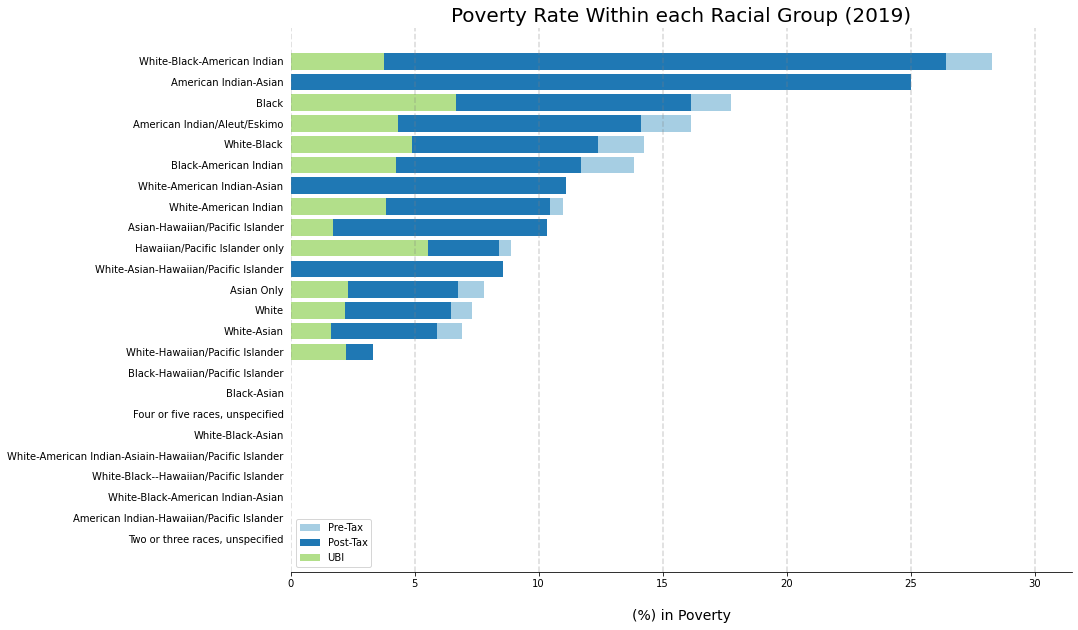

In [28]:
fig, ax = plt.subplots(figsize=(14, 10))

plt.barh(comp_ubi_race_pov['RACE_CAT'], comp_ubi_race_pov['RACE_POV'], color = ('#a6cee3'), label = "Pre-Tax")
plt.barh(comp_ubi_race_pov['RACE_CAT'], comp_ubi_race_pov['POST_RACE_POV'], color = ('#1f78b4'), label = "Post-Tax")
plt.barh(comp_ubi_race_pov['RACE_CAT'], comp_ubi_race_pov['UBI_RACE_POV'], color = ('#b2df8a'), label = "UBI")

# Set title
ax.set_title("Poverty Rate Within each Racial Group (2019)", size=20)

#Format x-axis
ax.set_xlabel("(%) in Poverty", labelpad=20, size=14) 
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw horizontal axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)


# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

#removing frame 
plt.tick_params(axis='y', which='both', top=False, left = False, right = False)
plt.tick_params(axis='x', which='both', top=False)
plt.legend()

The plot above is sorted in order of the racial group with the highest to lowest poverty rate for the baseline model, the pre-tax model. It does not display the percent change in the poverty rate for each racial group. Each colored bar can be read independently (i.e., it is not quite a stacked bar plot). For example, the top bar indicates that White-Black-American Indians had a poverty rate of 28% before taxes, 26% after normal taxes, and about under the UBI. No bars cover the data from other bars. 

Very interestingly, it appears that now the group with the highest rate of poverty is American Indian-Asian. Note however that under the original baseline, the poverty rate was highest among White Black American-Indians at almost 30%. It is clear from this plot that racial poverty has decreased dramatically. 

**Difference b/w UBI & Baseline Race Poverty**

**Post-UBI Poverty by Age**

*Recalculate Age-Group Column*: unfortunately recalculating the AGE_GROUP column is necessary to make the age-plot x-axis ticks accurate, since the dataframe dropped the 90 value between the two notebooks. This is understandable since there is no persons aged 90 or above in the dataset, so the maximum 90 value needs to be added back into the dataset each time it is re-loaded.

In [29]:
df = df.drop(['AGE_GROUP'], axis=1)
#generate income deciles poverty: 
bins= [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
#labels = ['15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64', '65-69','70-74','75-79','80-84','85-90']
labels = ['15','20','25','30','35','40','45','50','55','60', '65','70','75','80','85','90']
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

#check my work: 
df[["AGE", "AGE_GROUP"]].tail(10)

,AGE,AGE_GROUP
96563,48,45
96564,48,45
96565,74,70
96566,65,65
96567,39,35
96568,41,40
96569,71,70
96570,49,45
96571,36,35
96572,49,45


In [30]:
post_ubi_age_pov = df.groupby(['AGE_GROUP']).apply(ubi_pov_rate).to_frame().rename(columns={0: "UBI_AGE_GROUP_POV"}).reset_index()
post_ubi_age_pov
df=df.merge(post_ubi_age_pov, how = "left", on = "AGE_GROUP")

In [31]:
#check my work: 
#post_ubi_age_pov
#df["UBI_AGE_GROUP_POV"].value_counts()

In [32]:
#build age dataframe to compare age poverty by model
comp_ubi_age_pov = df.groupby(['AGE_GROUP'])[["AGE_POV_GROUP", "POST_AGE_GROUP_POV", "UBI_AGE_GROUP_POV"]].mean().reset_index().replace(np. nan,0).sort_values(by='AGE_GROUP')
comp_ubi_age_pov

,AGE_GROUP,AGE_POV_GROUP,POST_AGE_GROUP_POV,UBI_AGE_GROUP_POV
0,15,11.662497,9.063108,3.892132
1,20,9.178082,8.295282,2.587519
2,25,8.163823,7.003413,2.976109
3,30,7.688378,5.925926,2.988506
4,35,8.708592,6.444099,3.105590
5,40,7.538526,6.025267,2.332362
6,45,6.190933,5.122586,2.081907
7,50,7.006455,6.495428,2.380312
8,55,8.085928,7.808351,2.570601
9,60,8.940518,8.879698,2.578762


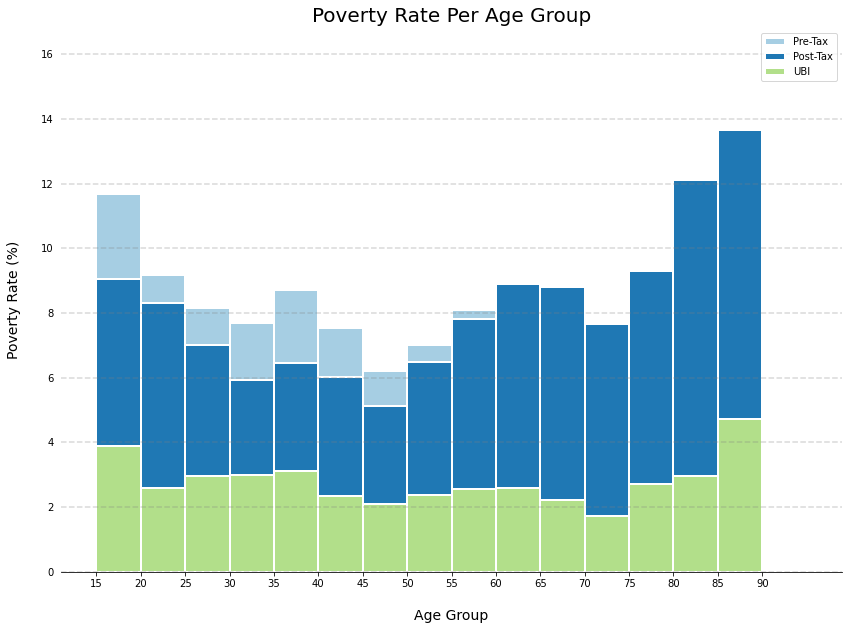

In [33]:

#plot poverty rate by age-group: 

fig, ax = plt.subplots(figsize=(14, 10))
plt.bar(comp_ubi_age_pov['AGE_GROUP'], comp_ubi_age_pov['AGE_POV_GROUP'], align = 'edge', color = ('#a6cee3'), width = 1, edgecolor = "white", linewidth = 2, label = "Pre-Tax")
plt.bar(comp_ubi_age_pov['AGE_GROUP'], comp_ubi_age_pov['POST_AGE_GROUP_POV'], align = 'edge', color = ('#1f78b4'), width = 1, edgecolor = "white", linewidth = 2, label = "Post-Tax")
plt.bar(comp_ubi_age_pov['AGE_GROUP'], comp_ubi_age_pov['UBI_AGE_GROUP_POV'], align = 'edge', color = ('#b2df8a'), width = 1, edgecolor = "white", linewidth = 2, label = "UBI")

# Set title
ax.set_title("Poverty Rate Per Age Group", size=20)

#Format x-axis
ax.set_xlabel("Age Group", labelpad=20, size=14) 
ax.set_xticks(comp_ubi_age_pov["AGE_GROUP"])
#plt.setp(ax.get_xticklabels(), rotation=45)
#ax.set_xticklabels(ax.get_xticks(), rotation = 45)
#ax.tick_params('x', rotation = 90)
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="on", labelleft="on")

# Set y-axis label
ax.set_ylabel("Poverty Rate (%)", labelpad=20, size=14)
# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)


# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

#removing frame 
plt.tick_params(axis='x', which='both', top=False)
plt.tick_params(axis='y', which='both', top=False, left = False, right = False)
plt.legend()
#plt.xticks(np.arange(15, 90, 5))

The results of this plot are very interesting, since the highest poverty rate under the UBI system for an age group shown here is about 5%, a sharp reduction from the almost 14% highest rate in the baseline age poverty. Note that the UBI did much better at reducing poverty among the elderly, who in the both the baseline and post-tax models had poverty rates at over 12%. 

Despite the fact that most children (people aged 17 and under) did not receive a UBI distribution (except for those heading their own household, of which there were 71 out of a total of 4,538 people under the age of 18), it appears that poverty for the smallest ages (15 - 19) also reduced. 

In [34]:
indep_children = df.set_index(["AGE", "FAMSIZE"]).loc[([15, 16, 17], 1), "CPSIDP"].count()
children = df.set_index(["AGE", "FAMSIZE"]).loc[[15, 16, 17], "CPSIDP"].count()
indep_children, children

(71, 4538)

**Post-UBI Income Inequality: Gini Index**

In [35]:
#define function to calculate Gini coefficient
def gini(x):
    """Takes income array and calculates the gini coefficient from it"""
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

hh = df.drop_duplicates(["CPSID"])

In [36]:
#define NumPy array of income values

#individual 
incomes = np.asarray(df['POST_UBI_INC'])

#calculate Gini coefficient for array of incomes
ind_gini = gini(incomes)

In [37]:
#household
incomes = np.asarray(hh['POST_UBI_HH'])

#calculate Gini coefficient for array of incomes
hh_gini = gini(incomes)

In [38]:
#store in dataframe

post_ubi = [ind_gini, hh_gini]

gini_index['Post_UBI Gini'] = post_ubi

gini_index

,Level,Pre-Tax Gini,Post-Tax Gini,Post_UBI Gini
0,individual,0.568350,0.564119,0.500017
1,household,0.482488,0.450054,0.435120


This UBI had quite strong poverty-reducing effects, and also relatively strong impact on income inequality. One should note  that the UBI modeled here has reduced income inequality when measured at the individual and household level the most compared to the U.S. tax system. These improvements are much stronger than the extremely small improvements demonstrated by the imposition of the standard U.S. tax system, despite it being praised as a progressive system. Again, this is not that surprising of a result - in general, a UBI isn't that effective at reducing income inequality per se (but is good at reducing poverty) because its nature is to take the exact same percentage of income from each household. This design does not reorder households on the income ladder - it simply makes the entire income ladder smaller. Thus, redistribution tends to be less progressive than the current tax system, since the current tax system can give a far higher percentage back to the bottom rung of the income ladder than a UBI can, which is limited by the fact that it is designed to give everyone, regardless of their income, the same distribution.

One should also note though that the pre-tax model generated here has no method to distinguish which individuals receive SSI (supplemental Security Income), Social Security, or disability benefits (which are all taxable), as long as they were reported as income for individuals who receive them, so those redistributive programs have already been built into the baseline before beginning this comparison. This is not ideal for comparison, of course, but building a model to distinguish between income from regularly disbursing welfare programs vs earned wages is a highly complex tax that  1) requires  more variables than available in the ASEC and 2) is outside the scope of this work, due to the complexity of that task. 


However, we can see from this result that the UBI's ability to reduce absolute poverty is stronger than its ability to reduce income inequality, for which it displayed only modest improvements in comparison to those of absolute poverty. Thus, if a policymaker's goal is to reduce absolute poverty, a UBI is an effective tool. However, it is less likely to reduce income inequality. 

## Revenue Neutral UBI (NUBI)

To generate this UBI, which is intended to be one which could be more realistically implemented, I will take the federal revenues from the current U.S. Welfare (Post Tax) model, and then take about 50% of that amount (the amount typically dedicated to welfare programs) and use that amount as the the ubi_rev (now nubi for neutral ubi) below to be divided up evenly in the sample. 

In [39]:
#total federal flat tax revenues: 
nubi_rev = 456179028 * 0.5
nubi_rev

#5) divide over the number of adults in the sample 
n = df.groupby("ADULT_CHILD").get_group("A")["CPSIDP"].count()
n

#amount of ubi distribution every adult receives: 
nubi = nubi_rev/n

print(f"Total NUBI Revenues = {nubi_rev} \nTotal Adults = {n}\nNUBI Redistribution Amount = {nubi}")


Total NUBI Revenues = 228089514.0 
Total Adults = 92106
NUBI Redistribution Amount = 2476.3806266692723


We can already see a dramatic cut in the UBI amount, but let us see whatever poverty and inequality reducing effects the NUBI may have. 

**New Post-NUBI Income**

In [40]:
#assign nubi distribution to a variable: 
def nubi_dist(row): 
    'write a function that calculates the amount of UBI distribution each individual receives'
    if row['ADULT_CHILD'] == "C": 
        val = 0
    elif row['ADULT_CHILD'] == "A": 
        val = nubi
    else: 
        val = "NaN" 
    return val 

#create new column 'Good' using the function above
df['NUBI_DIST'] = df.apply(nubi_dist, axis=1) #individual 

In [41]:
#check that function applied the UBI correctly: 
df.groupby("ADULT_CHILD").get_group("C")["UBI_DIST"].sum()

#it did - the children did not receive a UBI distribution. 

0.0

NUBI Individual Income: 

In [42]:
#define Post-UBI individual income 
df["POST_NUBI_INC"] = df["INCTOT"]+ df["NUBI_DIST"]



In [43]:
#Calculate change in Post-NUBI Individual Income 
def nubi_ind_change(row): 
    'write a function that calculates the amount of UBI distribution each individual receives'
    try:
        val = ((row["POST_NUBI_INC"] - row["INCTOT"])/row["INCTOT"])*100
    except ZeroDivisionError:
        val = ((row["POST_NUBI_INC"] - 1)/1)*100 
    return val 

df["NUBI_INCTOT_CHANGE"] = df.apply(nubi_ind_change, axis=1)
#Households that originally had 0 income end up dividing by 0, leaving inf. Need to replace this value to get accurate summary data. 


In [44]:

#check my results
df[["AGE", "ADULT_CHILD", "FAMSIZE", "INCTOT", "FEDTAX", "FLAT_TAX", "NUBI_DIST", "POST_NUBI_INC", "NUBI_INCTOT_CHANGE"]]

,AGE,ADULT_CHILD,FAMSIZE,INCTOT,FEDTAX,FLAT_TAX,NUBI_DIST,POST_NUBI_INC,NUBI_INCTOT_CHANGE
0,21,A,1,18000,600,2700.00,2476.380627,20476.380627,13.757670
1,85,A,1,21780,440,3267.00,2476.380627,24256.380627,11.369975
2,61,A,1,12000,0,1800.00,2476.380627,14476.380627,20.636505
3,73,A,2,10727,0,1609.05,2476.380627,13203.380627,23.085491
4,37,A,2,12000,0,1800.00,2476.380627,14476.380627,20.636505
...,...,...,...,...,...,...,...,...,...
96568,41,A,5,100200,0,15030.00,2476.380627,102676.380627,2.471438
96569,71,A,3,65671,3221,9850.65,2476.380627,68147.380627,3.770889
96570,49,A,3,23660,1209,3549.00,2476.380627,26136.380627,10.466528
96571,36,A,3,0,8199,0.00,2476.380627,2476.380627,247538.062667


NUBI Household Income: 

In [45]:
post_nubi_hh = df.groupby(['CPSID'])['POST_NUBI_INC'].sum().to_frame().rename(columns={"POST_NUBI_INC": "POST_NUBI_HH"}).reset_index()
post_nubi_hh
df = df.merge(post_nubi_hh, how = "left", on = "CPSID")
#df.head()

In [46]:
#calculate change in Household Income Due to UBI: 

def nubi_hh_change(row): 
    'calculate change in Household Income Due to NUBI.'
    try:
        val = ((row["POST_NUBI_HH"] - row["HHINCOME"])/row["HHINCOME"])*100
    except ZeroDivisionError:
        val = ((row["POST_NUBI_HH"] - 1)/1)*100 
    return val 

In [47]:
#create new column 'Good' using the function above
df['NUBI_HH_CHANGE'] = df.apply(nubi_hh_change, axis=1)


In [48]:

#check my results
df[["AGE", "ADULT_CHILD", "CPSID", "FAMSIZE", "HHINCOME", "FEDTAX", "FLAT_TAX", "NUBI_DIST", "POST_NUBI_HH", "NUBI_HH_CHANGE"]]

,AGE,ADULT_CHILD,CPSID,FAMSIZE,HHINCOME,FEDTAX,FLAT_TAX,NUBI_DIST,POST_NUBI_HH,NUBI_HH_CHANGE
0,21,A,20180302857800,1,18000,600,2700.00,2476.380627,20476.380627,13.757670
1,85,A,20190302835500,1,21780,440,3267.00,2476.380627,24256.380627,11.369975
2,61,A,20190302846800,1,12000,0,1800.00,2476.380627,14476.380627,20.636505
3,73,A,20190302822300,2,22727,0,1609.05,2476.380627,27679.761253,21.792411
4,37,A,20190302822300,2,22727,0,1800.00,2476.380627,27679.761253,21.792411
...,...,...,...,...,...,...,...,...,...,...
96568,41,A,20180201951400,5,135200,0,15030.00,2476.380627,140152.761253,3.663285
96569,71,A,20190101933000,3,89331,3221,9850.65,2476.380627,94283.761253,5.544281
96570,49,A,20190101933000,3,89331,1209,3549.00,2476.380627,94283.761253,5.544281
96571,36,A,20190101883200,3,110000,8199,0.00,2476.380627,114952.761253,4.502510


In [49]:
#reassign hh to include the new variables just calculated into household data. 
hh = df.drop_duplicates(["CPSID"])

In [50]:
#view changes 

ind_summary = df.agg(
    {
        "INCTOT": ["min", "max", "mean", "median"], 
        "POST_UBI_INC": ["min", "max", "mean", "median"],
        "POST_NUBI_INC": ["min", "max", "mean", "median"]
        
    }
)


hh_summary = hh.agg(
    {
        "HHINCOME": ["min", "max", "mean", "median"], 
        "POST_UBI_HH": ["min", "max", "mean", "median"],
        "POST_NUBI_HH": ["min", "max", "mean", "median"]
        
    }
)

ind_summary.round()

,INCTOT,POST_UBI_INC,POST_NUBI_INC
min,-13000.0,-5909.0,-10524.0
max,2055999.0,2063090.0,2058475.0
mean,45183.0,51947.0,47545.0
median,29625.0,36703.0,32096.0


**NUBI Income Distribution**

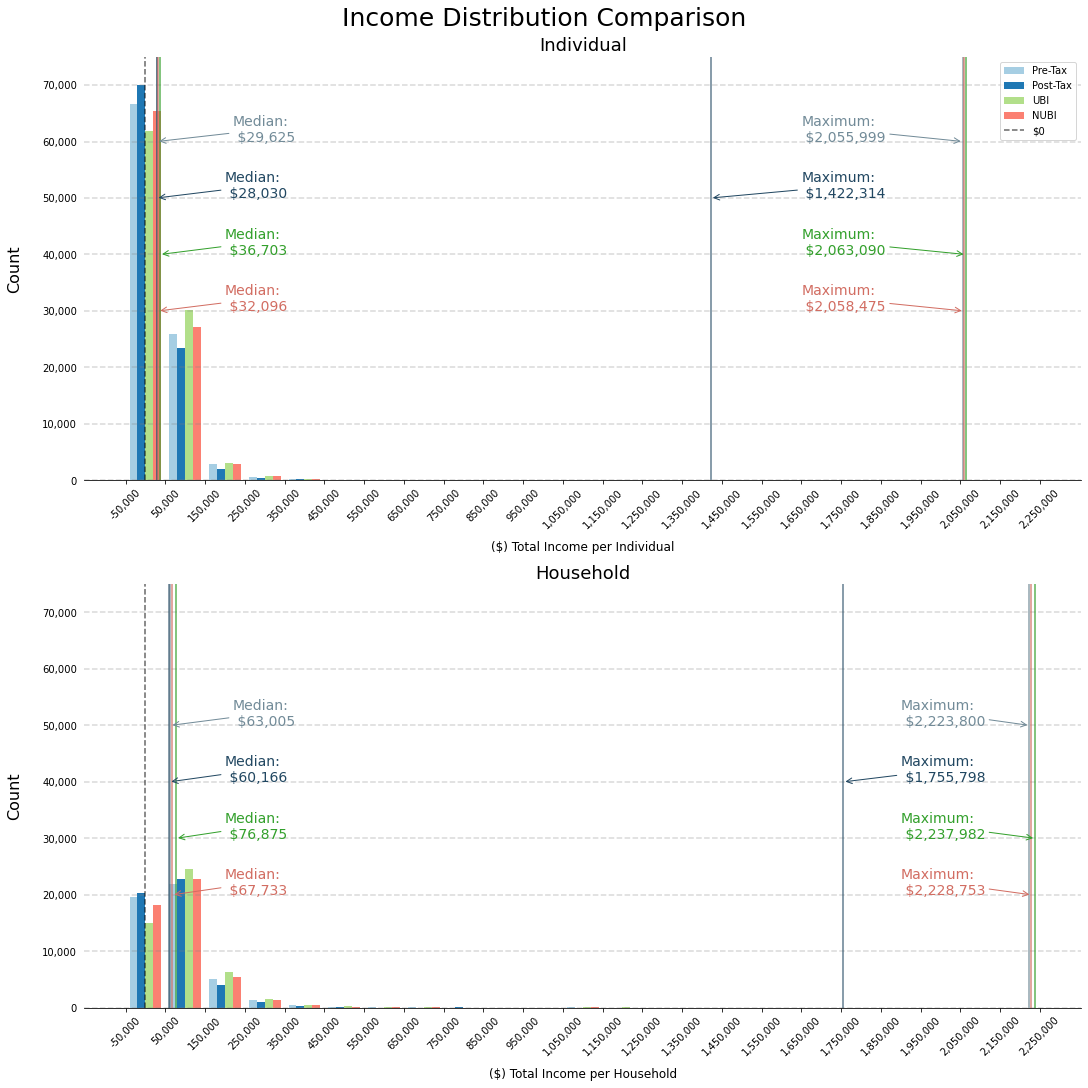

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)

bins = np.arange(-50_000, 2_300_000, 100_000)

#assigning long colors 
pre_tax = (0.44749456473280025, 0.5442189568340771, 0.5952299195805278)
post_tax = (0.13127338987823528, 0.27751527607814364, 0.38095970787350786)
ubi = ('#33a02c')
nubi_main = ("#fb8072")
nubi_label = (0.8238685424331371, 0.4290123592475775, 0.38441179024460176)

axes[0].hist([df['INCTOT'], df['POST_TAX_INC_IN'], df['POST_UBI_INC'], df['POST_NUBI_INC']], bins, label=['Pre-Tax', 'Post-Tax', "UBI", "NUBI"], color = [("#a6cee3"), ("#1f78b4"), ('#b2df8a'), nubi_main], align = 'mid')
axes[1].hist([hh['HHINCOME'], hh['POST_TAX_INC_HH'], hh['POST_UBI_HH'], hh['POST_NUBI_HH']], bins, label=['Pre-Tax', 'Post-Tax', "UBI"], color = [("#a6cee3"), ("#1f78b4"), ('#b2df8a'), nubi_main ], align = 'mid')

# Set title
fig.suptitle("Income Distribution Comparison", size=25) #y=0.93
axes[0].set_title("Individual", size=18) #, y=1
axes[1].set_title("Household", size=18) #y=0.5

#####################################################INDIVIDUAL
#Format x-axis
axes[0].set_xticks(bins)
axes[0].set_xlabel("($) Total Income per Individual", labelpad=10, size=12) 
axes[0].ticklabel_format(useOffset=False, style='plain')
#ax.set_xticks(np.arange(-200_000, 2_500_000, 100_000))
axes[0].set_xticklabels(axes[0].get_xticks(), rotation = 45)
axes[0].tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
axes[0].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Set y-axis label
axes[0].set_ylabel("Count", labelpad=20, size=16)
# Draw horizontal axis lines
vals = axes[0].get_yticks()
for tick in vals:
    axes[0].axhline(y=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)
axes[0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[0].set_ylim(0, 75_000)

#adding other lines
axes[0].axvline(x=0, alpha=0.6, linestyle = "dashed", color='black', zorder=1, label = "$0")

#Pre-Tax
axes[0].axvline(x=max(df['INCTOT']), alpha=0.8, color=pre_tax, zorder=1)
axes[0].axvline(x=(df['INCTOT'].median()), alpha=0.8, color=pre_tax, zorder=1)

#Post-Tax
axes[0].axvline(x=max(df['POST_TAX_INC_IN']), alpha=0.7, color=post_tax, zorder=1)
axes[0].axvline(x=(df['POST_TAX_INC_IN'].median()), alpha=0.7, color=post_tax, zorder=1)

#UBI
axes[0].axvline(x=max(df['POST_UBI_INC']), alpha=0.8, color=ubi, zorder=1)
axes[0].axvline(x=(df['POST_UBI_INC'].median()), alpha=0.8, color=ubi, zorder=1)

#NUBI
axes[0].axvline(x=max(df['POST_NUBI_INC']), alpha=0.8, color=nubi_label, zorder=1)
axes[0].axvline(x=(df['POST_NUBI_INC'].median()), alpha=0.8, color=nubi_label, zorder=1)


#annotations
#Pre-Tax
axes[0].annotate("Maximum:\n $2,055,999", xy=(max(df['INCTOT']), 60000), xytext=(1650000, 60000), arrowprops=dict(color=pre_tax, arrowstyle="->"), size = 14, color=pre_tax)
axes[0].annotate("Median:\n $29,625", xy=(df['INCTOT'].median(), 60000), xytext=(220000, 60000), arrowprops=dict(color=pre_tax, arrowstyle="->"), size = 14, color=pre_tax)

#Post-Tax
axes[0].annotate("Maximum:\n $1,422,314", xy=(max(df['POST_TAX_INC_IN']), 50000), xytext=(1650000, 50000), arrowprops=dict(color=post_tax, arrowstyle="->"), size = 14, color=post_tax)
axes[0].annotate("Median:\n $28,030", xy=(df['POST_TAX_INC_IN'].median(), 50000), xytext=(200000, 50000), arrowprops=dict(color=post_tax, arrowstyle="->"), size = 14, color=post_tax)

#UBI
axes[0].annotate("Maximum:\n $2,063,090", xy=(max(df['POST_UBI_INC']), 40000), xytext=(1650000, 40000), arrowprops=dict(color=ubi, arrowstyle="->"), size = 14, color= ubi)
axes[0].annotate("Median:\n $36,703", xy=(df['POST_UBI_INC'].median(), 40000), xytext=(200000, 40000), arrowprops=dict(color=ubi, arrowstyle="->"), size = 14, color=ubi)

#NUBI
axes[0].annotate("Maximum:\n $2,058,475", xy=(max(df['POST_NUBI_INC']), 30000), xytext=(1650000, 30000), arrowprops=dict(color=nubi_label, arrowstyle="->"), size = 14, color= nubi_label)
axes[0].annotate("Median:\n $32,096", xy=(df['POST_NUBI_INC'].median(), 30000), xytext=(200000, 30000), arrowprops=dict(color=nubi_label, arrowstyle="->"), size = 14, color=nubi_label)

# Despine
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)



#####################################################HOUSEHOLD


#Format x-axis
axes[1].set_xticks(bins)
axes[1].set_xlabel("($) Total Income per Household", labelpad=10, size=12) 
axes[1].ticklabel_format(useOffset=False, style='plain')
#ax.set_xticks(np.arange(-200_000, 2_500_000, 100_000))
axes[1].set_xticklabels(axes[1].get_xticks(), rotation = 45)
axes[1].tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Set y-axis label
# Draw horizontal axis lines
vals = axes[0].get_yticks()
for tick in vals:
    axes[1].axhline(y=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)
axes[1].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[1].set_ylim(0, 75_000)
axes[1].set_ylabel("Count", labelpad=20, size=16)

#adding other lines
axes[1].axvline(x=0, alpha=0.6, linestyle = "dashed", color='black', zorder=1, label = "$0")

#Pre-Tax
axes[1].axvline(x=max(hh['HHINCOME']), alpha=0.8, color=(0.44749456473280025, 0.5442189568340771, 0.5952299195805278), zorder=1)
axes[1].axvline(x=(hh['HHINCOME'].median()), alpha=0.8, color=(0.44749456473280025, 0.5442189568340771, 0.5952299195805278), zorder=1)

#Post-Tax
axes[1].axvline(x=max(hh['POST_TAX_INC_HH']), alpha=0.7, color=(0.13127338987823528, 0.27751527607814364, 0.38095970787350786), zorder=1)
axes[1].axvline(x=(hh['POST_TAX_INC_HH'].median()), alpha=0.7, color=(0.13127338987823528, 0.27751527607814364, 0.38095970787350786), zorder=1)

#UBI
axes[1].axvline(x=max(hh['POST_UBI_HH']), alpha=0.8, color=ubi, zorder=1)
axes[1].axvline(x=(hh['POST_UBI_HH'].median()), alpha=0.8, color=ubi, zorder=1)

#UBI
axes[1].axvline(x=max(hh['POST_NUBI_HH']), alpha=0.8, color=nubi_label, zorder=1)
axes[1].axvline(x=(hh['POST_NUBI_HH'].median()), alpha=0.8, color=nubi_label, zorder=1)


#annotations
#Pre-Tax
axes[1].annotate("Maximum:\n $2,223,800", xy=(max(hh['HHINCOME']), 50000), xytext=(1900000, 50000), arrowprops=dict(color=pre_tax, arrowstyle="->"), size = 14, color=pre_tax)
axes[1].annotate("Median:\n $63,005", xy=(hh['HHINCOME'].median(), 50000), xytext=(220000, 50000), arrowprops=dict(color=pre_tax, arrowstyle="->"), size = 14, color=pre_tax)

#Post-Tax
axes[1].annotate("Maximum:\n $1,755,798", xy=(max(hh['POST_TAX_INC_HH']), 40000), xytext=(1900000, 40000), arrowprops=dict(color=post_tax, arrowstyle="->"), size = 14, color=post_tax)
axes[1].annotate("Median:\n $60,166", xy=(hh['POST_TAX_INC_HH'].median(), 40000), xytext=(200000, 40000), arrowprops=dict(color=post_tax, arrowstyle="->"), size = 14, color=post_tax)

#UBI
axes[1].annotate("Maximum:\n $2,237,982", xy=(max(hh['POST_UBI_HH']), 30000), xytext=(1900000, 30000), arrowprops=dict(color=ubi, arrowstyle="->"), size = 14, color= ubi)
axes[1].annotate("Median:\n $76,875", xy=(hh['POST_UBI_HH'].median(), 30000), xytext=(200000, 30000), arrowprops=dict(color=ubi, arrowstyle="->"), size = 14, color=ubi)

#NUBI
axes[1].annotate("Maximum:\n $2,228,753", xy=(max(hh['POST_NUBI_HH']), 20000), xytext=(1900000, 20000), arrowprops=dict(color=nubi_label, arrowstyle="->"), size = 14, color= nubi_label)
axes[1].annotate("Median:\n $67,733", xy=(hh['POST_NUBI_HH'].median(), 20000), xytext=(200000, 20000), arrowprops=dict(color=nubi_label, arrowstyle="->"), size = 14, color=nubi_label)

# Despine
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)

#####################################################BOTH

axes[0].tick_params(axis='x', which='both', top=False)
axes[1].tick_params(axis='x', which='both', top=False)
axes[0].tick_params(left = False, right = False)
axes[1].tick_params(left = False, right = False)
axes[0].legend(loc='upper right', ncol=1)
plt.show() 
#plt.subplots_adjust(left=None, bottom=0.9, right=None, top=0.9, wspace=0.2, hspace=0.2)


**Post-NUBI Poverty Rate**

In [52]:

#Classify each individual as either poor or not post-NUBI: 

def pov_nubi(row): 
    'write a function that defines someone as poor if their post-NUBI income is less than than the poverty threshold for their family size'
    if row['POST_NUBI_HH'] <= row['THRESH']: 
        val = 1
    else: 
        val = 0
    return val 


#create new column 'Good' using the function above
df['POV_POST_NUBI'] = df.apply(pov_nubi, axis=1)
#calculate post-ubi poverty rate: 


In [53]:
def nubi_pov_rate(df):
    """
    Calculates poverty rate for any demographic you are interested in.
    
    Arguments:
    ----------
        df (pandas dataframe): a dataframe to calculate the poverty rate for.
        
    Returns:
    --------
        the poverty rate
    """
    try: 
        nubi_pov_rate = (sum(df['POV_POST_NUBI'])/len(df))*100
    except ZeroDivisionError: 
        nubi_pov_rate = 0 #this will cover the later case where the AGE_GROUP 90 has length 0 (no other groups do). 

    return(nubi_pov_rate)

In [54]:
#reassign hh to include the new variables just calculated. 
hh = df.drop_duplicates(["CPSID"])

In [55]:
#calculate post-nubi poverty rate: 

#individual

ind_pov_perc= (sum(df['POV_POST_NUBI'])/len(df))*100

#household
hh_pov_perc= (sum(hh['POV_POST_NUBI'])/len(hh))*100



In [56]:
#store in dataframe

post_nubi = [ind_pov_perc, hh_pov_perc]
poverty_rates['Post-NUBI Poverty Rate (%)'] = post_nubi

poverty_rates

,Level,Pre-Tax Poverty Rate (%),Post-Tax Poverty Rate (%),Post-UBI Poverty Rate (%),Post-NUBI Poverty Rate (%)
0,individual,8.580038,7.642923,2.702619,5.909519
1,household,10.668767,10.668767,3.772427,7.612365


The poverty-reducing effects of this policy are not as high as those of the classic UBI, likely because the amount of funds at its disposal are far lower, but still this more realistic UBI is far outperforming the U.S. Welfare system represented in the Post-Tax Model in Part 1. These are incredibly strong results for this far more affordable program. 


**Post-NUBI Poverty by Race**

In [57]:
#create nubi race poverty subset for plotting. Plot difference between ubi and baseline. 
race_nubi_pov = df.groupby(['RACE_CAT']).apply(nubi_pov_rate).to_frame().rename(columns={0: "NUBI_RACE_POV"}).reset_index().sort_values(by='NUBI_RACE_POV')
df = df.merge(race_nubi_pov, how = "left", on = "RACE_CAT")
race_nubi_pov

,RACE_CAT,NUBI_RACE_POV
11,"Two or three races, unspecified",0.000000
1,American Indian-Hawaiian/Pacific Islander,0.000000
21,White-Black-American Indian-Asian,0.000000
19,White-Black--Hawaiian/Pacific Islander,0.000000
14,White-American Indian-Asiain-Hawaiian/Pacific ...,0.000000
22,White-Black-Asian,0.000000
9,"Four or five races, unspecified",0.000000
7,Black-Asian,0.000000
8,Black-Hawaiian/Pacific Islander,0.000000
23,White-Hawaiian/Pacific Islander,2.222222


In [58]:
#build race dataframe 
comp_nubi_race_pov = df.groupby(['RACE_CAT'])[["RACE_POV", "POST_RACE_POV", 'NUBI_RACE_POV', "UBI_RACE_POV"]].mean().reset_index().sort_values(by='RACE_POV')
comp_nubi_race_pov


,RACE_CAT,RACE_POV,POST_RACE_POV,NUBI_RACE_POV,UBI_RACE_POV
11,"Two or three races, unspecified",0.000000,0.000000,0.000000,0.000000
1,American Indian-Hawaiian/Pacific Islander,0.000000,0.000000,0.000000,0.000000
21,White-Black-American Indian-Asian,0.000000,0.000000,0.000000,0.000000
19,White-Black--Hawaiian/Pacific Islander,0.000000,0.000000,0.000000,0.000000
14,White-American Indian-Asiain-Hawaiian/Pacific ...,0.000000,0.000000,0.000000,0.000000
22,White-Black-Asian,0.000000,0.000000,0.000000,0.000000
9,"Four or five races, unspecified",0.000000,0.000000,0.000000,0.000000
7,Black-Asian,0.000000,0.000000,0.000000,0.000000
8,Black-Hawaiian/Pacific Islander,0.000000,0.000000,0.000000,0.000000
23,White-Hawaiian/Pacific Islander,3.333333,3.333333,2.222222,2.222222


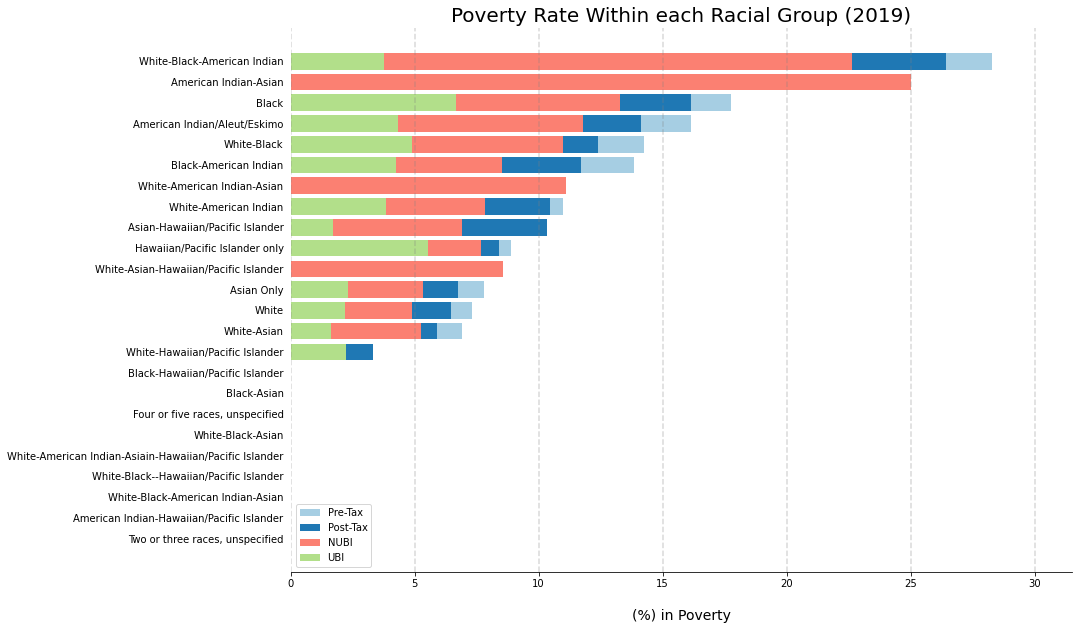

In [59]:
fig, ax = plt.subplots(figsize=(14, 10))

plt.barh(comp_nubi_race_pov['RACE_CAT'], comp_nubi_race_pov['RACE_POV'], color = ('#a6cee3'), label = "Pre-Tax")
plt.barh(comp_nubi_race_pov['RACE_CAT'], comp_nubi_race_pov['POST_RACE_POV'], color = ('#1f78b4'), label = "Post-Tax")
plt.barh(comp_nubi_race_pov['RACE_CAT'], comp_nubi_race_pov['NUBI_RACE_POV'], color = ('#fb8072'), label = "NUBI")
plt.barh(comp_nubi_race_pov['RACE_CAT'], comp_nubi_race_pov['UBI_RACE_POV'], color = ('#b2df8a'), label = "UBI")

# Set title
ax.set_title("Poverty Rate Within each Racial Group (2019)", size=20)

#Format x-axis
ax.set_xlabel("(%) in Poverty", labelpad=20, size=14) 
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw horizontal axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)


# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

#removing frame 
plt.tick_params(axis='y', which='both', top=False, left = False, right = False)
plt.tick_params(axis='x', which='both', top=False)
plt.legend()

**Post-NUBI Poverty by Age**

In [60]:
post_nubi_age_pov = df.groupby(['AGE_GROUP']).apply(nubi_pov_rate).to_frame().rename(columns={0: "NUBI_AGE_GROUP_POV"}).reset_index()
post_nubi_age_pov
df=df.merge(post_nubi_age_pov, how = "left", on = "AGE_GROUP")



In [61]:
#check my work: 
post_nubi_age_pov
#df["NUBI_AGE_GROUP_POV"].value_counts()
#build age dataframe to compare age poverty by model



,AGE_GROUP,NUBI_AGE_GROUP_POV
0,15,8.409786
1,20,6.301370
2,25,5.952218
3,30,5.670498
4,35,6.133540
5,40,5.164515
6,45,4.355568
7,50,4.814416
8,55,5.563601
9,60,6.203625


In [62]:
comp_nubi_age_pov = df.groupby(['AGE_GROUP'])[["AGE_POV_GROUP", "POST_AGE_GROUP_POV", "NUBI_AGE_GROUP_POV", "UBI_AGE_GROUP_POV"]].mean().reset_index().replace(np. nan,0).sort_values(by='AGE_GROUP')
comp_nubi_age_pov

,AGE_GROUP,AGE_POV_GROUP,POST_AGE_GROUP_POV,NUBI_AGE_GROUP_POV,UBI_AGE_GROUP_POV
0,15,11.662497,9.063108,8.409786,3.892132
1,20,9.178082,8.295282,6.301370,2.587519
2,25,8.163823,7.003413,5.952218,2.976109
3,30,7.688378,5.925926,5.670498,2.988506
4,35,8.708592,6.444099,6.133540,3.105590
5,40,7.538526,6.025267,5.164515,2.332362
6,45,6.190933,5.122586,4.355568,2.081907
7,50,7.006455,6.495428,4.814416,2.380312
8,55,8.085928,7.808351,5.563601,2.570601
9,60,8.940518,8.879698,6.203625,2.578762


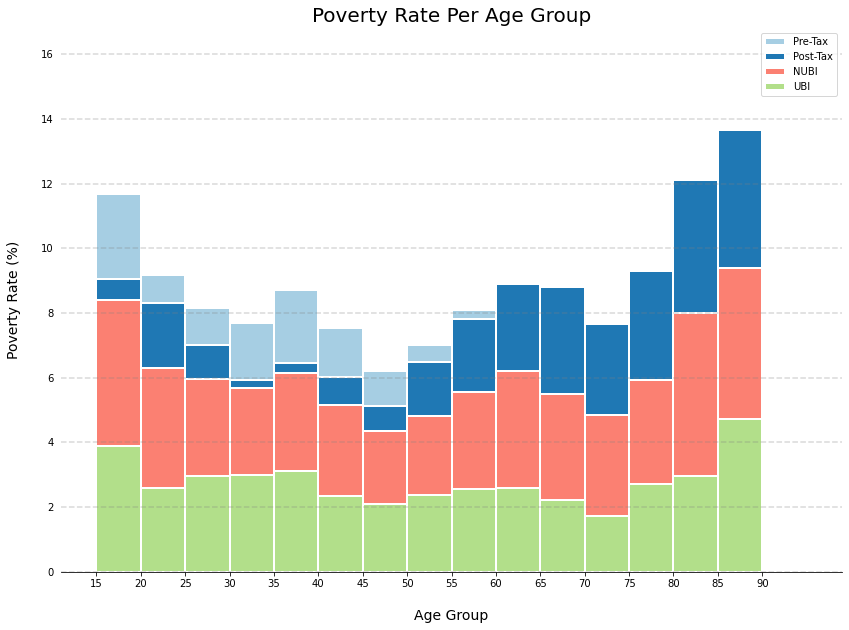

In [63]:
#plot poverty rate by age-group: 

fig, ax = plt.subplots(figsize=(14, 10))
plt.bar(comp_nubi_age_pov['AGE_GROUP'], comp_nubi_age_pov['AGE_POV_GROUP'], align = 'edge', color = ('#a6cee3'), width = 1, edgecolor = "white", linewidth = 2, label = "Pre-Tax")
plt.bar(comp_nubi_age_pov['AGE_GROUP'], comp_nubi_age_pov['POST_AGE_GROUP_POV'], align = 'edge', color = ('#1f78b4'), width = 1, edgecolor = "white", linewidth = 2, label = "Post-Tax")
plt.bar(comp_nubi_age_pov['AGE_GROUP'], comp_nubi_age_pov['NUBI_AGE_GROUP_POV'], align = 'edge', color = ('#fb8072'), width = 1, edgecolor = "white", linewidth = 2, label = "NUBI")
plt.bar(comp_nubi_age_pov['AGE_GROUP'], comp_nubi_age_pov['UBI_AGE_GROUP_POV'], align = 'edge', color = ('#b2df8a'), width = 1, edgecolor = "white", linewidth = 2, label = "UBI")

# Set title
ax.set_title("Poverty Rate Per Age Group", size=20)

#Format x-axis
ax.set_xlabel("Age Group", labelpad=20, size=14) 
ax.set_xticks(comp_ubi_age_pov["AGE_GROUP"])
#plt.setp(ax.get_xticklabels(), rotation=45)
#ax.set_xticklabels(ax.get_xticks(), rotation = 45)
#ax.tick_params('x', rotation = 90)
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="on", labelleft="on")

# Set y-axis label
ax.set_ylabel("Poverty Rate (%)", labelpad=20, size=14)
# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)


# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

#removing frame 
plt.tick_params(axis='x', which='both', top=False)
plt.tick_params(axis='y', which='both', top=False, left = False, right = False)
plt.legend()
#plt.xticks(np.arange(15, 90, 5))

Although the NUBI does not reduce the poverty rate for each age group more than the generous UBI, which is understandable, it still reduces age poverty compared to results in the baseline. 

**Post-NUBI Income Inequality: Gini Index**

In [64]:
#define NumPy array of income values
incomes = np.asarray(df['POST_NUBI_INC'])

#calculate Gini coefficient for array of incomes
ind_gini = gini(incomes)

In [65]:
#reassign hh to include the new variables just calculated. 
hh = df.drop_duplicates(["CPSID"])

#define NumPy array of income values
incomes = np.asarray(hh['POST_NUBI_HH'])

#calculate Gini coefficient for array of incomes
hh_gini = gini(incomes)

In [66]:
#store in dataframe

post_nubi = [ind_gini, hh_gini]

gini_index['Post-NUBI Gini'] = post_nubi

gini_index

,Level,Pre-Tax Gini,Post-Tax Gini,Post_UBI Gini,Post-NUBI Gini
0,individual,0.568350,0.564119,0.500017,0.542234
1,household,0.482488,0.450054,0.435120,0.464097


The drop in income inequality due to the NUBI, much like the UBI, is relatively small, although still an improvement over the baseline's Gini coefficient of to 
0.48248803295902304. For the same reasons as mentioned previously under the UBI scheme, UBI schemes tend to not be as effective at reducing income inequality as they are at reducing absolute poverty. Even so, the poverty-reducing abilities of this much more realistically implementable NUBI are quite extensive for the affordable poverty reductions it simultaneously provides (although the Gini reductions of the classic UBI are far higher), making this perhaps a better policy choice for a policymaker than the classic UBI or the post-tax model. 

## Discussion and Conclusion

Now that all the models' results in terms of poverty reduction have been displayed, it is time to compare them. Overall, it appears that, in terms of strongest ability to reduce absolute poverty, the classic UBI model wins, having demonstrated the strongest reductions in poverty rates overall, for households, individuals, and for the demographics reviewed. The main flaw of the UBI is the heavy amount of tax revenue it requires to carry out this mission - and the fact that 100% of its tax revenues are devoted to the welfare system it creates. This is of course extremely unrealistic. Thus, the UBI was followed by the more realistic NUBI, which also demonstrated strong reductions in overall poverty rates beyond those of the regular tax system, though not to the same extent that the UBI did - however, it brought these gains at half the cost of the existing federal revenues, making it far more affordable and realistic to implement. At first blush, these results indicate a general win for non-progressive tax schemes in favor of a universal distribution mechanism. 

There are however some weaknesses to these two systems. Of course, one must note their high price tags, but they are also limited by the fact that the scope of this project, which has prevented me from crediting income from welfare programs to those programs, due to lack of variables and simply the complexity of such a task outweighing the nature of this project. Disability, SSI, and social security programs are a hallmark of the U.S. welfare system, if not its tax system, so a true comparison of the entire welfare system (instead of only the tax system, as I have done here) would require further splitting benefits. If that were done, it is likely that the poverty-reducing abilities of the current welfare system would increase dramatically, particularly for the elderly. However, it is worth noting that even without separating out SSI, social security, or disability income, a large majority of the sample's 60+ population is technically living in poverty even before taxes. These results should be evidence that whatever welfare programs we currently have are dramatically underserving our elderly population (at least in this sample). 

A further limitation of these results is that the only children included (children under 18) are those who report income taxes due to working. The FAMSIZE variable does include all cohabitating family members, but this means that children's poverty is more than likely being undercounted. Furthermore, these results are entirely limited to the existing sample, and also do not include tax benefits or liabilities owed to individuals' states or localities. Depending on where one lives, tax-based benefit programs may be far higher or lower, and a UBI would be expected to have different interaction effects with each of these additional 50+ welfare systems. 

Additionally, if it is a policymaker's intent to reduce income inequality by instituting some form of a UBI, it is not clear that even the dramatically generous UBI would have a dramatic effect. Reasons for flat-tax systems' inability to reduce income inequalty have been explained in previous Gini Coefficient sections, but it is an important point to mention. However, if one's goal is poverty-reduction, these results are strongly in the UBI and NUBI's favor. One should also note that the UBI and NUBI were especially effective at reducing poverty rates for minority groups (see Appendix: Race), particlarly in comparison to the existing tax system. 

In general, this work lends itself to a great deal of further research, not the least of which is incorporating Social Security, Disability, and SSI income considerations. This work also brings up an additional avenue of research to investigate: whether benefits should be delivered individually or based on one's household. In this model, I have chosen to grant benefits to each independent adult, but giving benefits to each household could have differential effects, especially for traditionally less powerful groups, like women and adolescents, who traditionally have had less control over finances. Further research also needs to investigate the impact of timing of distribution, and whether wellbeing is affected by receiving the UBI as a reduction in taxes or split up as monthly income (though such work would need to be experimental and less focused on tax modeling). 

## References

Dalaker, J., Poverty in the United States in 2020 (2022). Congressional Research Service. 

Flood, S., et al. *Integrated Public Use Microdata Series, Current Population Survey: Version 10.0* [dataset]. Minneapolis, MN: IPUMS, 2022.
https://doi.org/10.18128/D030.V10.0

Flood, S., &amp; Pacas, J. (2016). (working paper). Using the Annual Social and Economic Supplement with Current Population Survey Panels. Washington, D.C.: U.S. Census Bureau. 

Ghatak, M., &amp; Maniquet, F. (2019). Universal Basic Income: Some Theoretical Aspects. *Annual Review of Economics, 11*(1), 895–928. https://doi.org/10.1146/annurev-economics-080218-030220 

StatsDirect. (n.d.). *Gini Coefficient of Inequality.* Statistical Help. Retrieved December 23, 2022, from https://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm 

U.S. Department of Health and Human Services. (2022, January 12). *Poverty Guidelines.* Office of the Assistant Secretary of Planning and Evaluation. Retrieved December 23, 2022, from https://aspe.hhs.gov/topics/poverty-economic-mobility/poverty-guidelines 

U.S. Department of Health and Human Services. (n.d.). *Frequently Asked Questions Related to the Poverty Guidelines and Poverty.* Office of the Assistant Secretary For Planning and Evaluation. Retrieved December 23, 2022, from https://aspe.hhs.gov/topics/poverty-economic-mobility/poverty-guidelines/frequently-asked-questions-related-poverty-guidelines-poverty#before 

University of Wisconsin-Madison. (n.d.). *How is Poverty Measured?* Institute for Research on Poverty. Retrieved December 23, 2022, from https://www.irp.wisc.edu/resources/how-is-poverty-measured/ 

## Appendix 

**Percent Change in Poverty Rate from Pre-Tax Levels by Race**

In [67]:
race_perc_change=df.groupby(['RACE_CAT'])[["POV_PRE_TAX", "POV_POST_TAX","POV_POST_UBI", "POV_POST_NUBI"]].sum().reset_index()
race_perc_change['RACE_PERC_CHANGE_TAX'] = ((race_perc_change['POV_POST_TAX'] - race_perc_change['POV_PRE_TAX'])/race_perc_change['POV_PRE_TAX'])*100
race_perc_change['RACE_PERC_CHANGE_UBI'] = ((race_perc_change['POV_POST_UBI'] - race_perc_change['POV_PRE_TAX'])/race_perc_change['POV_PRE_TAX'])*100
race_perc_change['RACE_PERC_CHANGE_NUBI'] = ((race_perc_change['POV_POST_NUBI'] - race_perc_change['POV_PRE_TAX'])/race_perc_change['POV_PRE_TAX'])*100
#comp_race_pov_ubi['RACE_PERC_CHANGE_TAX'] = df.groupby(['RACE_CAT'])[["POV_PRE_TAX", "POV_POST_TAX"]].apply(pov_perc_change, start_col = 'POV_PRE_TAX', end_col = 'POV_POST_TAX')
race_perc_change = race_perc_change.fillna(0).sort_values(by='RACE_PERC_CHANGE_UBI', ascending = False)

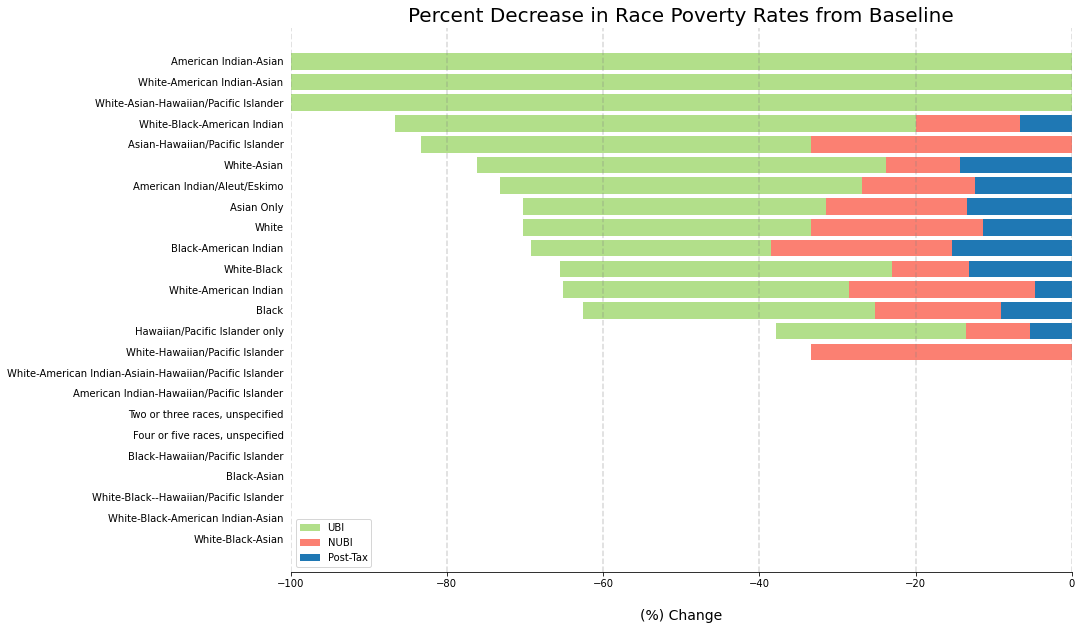

In [68]:
#plot % Change in Race Poverty Across Models: 

fig, ax = plt.subplots(figsize=(14, 10))

plt.barh(race_perc_change['RACE_CAT'], race_perc_change['RACE_PERC_CHANGE_UBI'], color = ('#b2df8a'), label = "UBI")
plt.barh(race_perc_change['RACE_CAT'], race_perc_change['RACE_PERC_CHANGE_NUBI'], color = ('#fb8072'), label = "NUBI")
plt.barh(race_perc_change['RACE_CAT'], race_perc_change['RACE_PERC_CHANGE_TAX'], color = ('#1f78b4'), label = "Post-Tax")



# Set title
ax.set_title("Percent Decrease in Race Poverty Rates from Baseline", size=20)

#Format x-axis
ax.set_xlabel("(%) Change", labelpad=20, size=14) 
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
ax.set_xlim(-100, 0)

# Draw horizontal axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)


# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

#removing frame 
plt.tick_params(axis='y', which='both', top=False, left = False, right = False)
plt.tick_params(axis='x', which='both', top=False)
plt.legend()

Note that again, these percent decreases in poverty rates by race from the initial baseline poverty rates are misleading, since small racial groups (like the American Indian-Asians) have 0 or 1 total members in their population - thus moving 1 out of poverty means a decrease of 100%. Regardless, one can see from this plot that the UBI (as expected) was most effective at decreasing the percent of individuals in each racial group that were in poverty, with the NUBI following behind and continuing to perform better than the U.S tax system. 

**UBI Percent Change in Poverty Rate by Age**

In [69]:
age_perc_change=df.groupby(['AGE_GROUP'])[["POV_PRE_TAX", "POV_POST_TAX","POV_POST_UBI", "POV_POST_NUBI"]].sum().reset_index()
age_perc_change['AGE_PERC_CHANGE_TAX'] = ((age_perc_change['POV_POST_TAX'] - age_perc_change['POV_PRE_TAX'])/age_perc_change['POV_PRE_TAX'])*100
age_perc_change['AGE_PERC_CHANGE_UBI'] = ((age_perc_change['POV_POST_UBI'] - age_perc_change['POV_PRE_TAX'])/age_perc_change['POV_PRE_TAX'])*100
age_perc_change['AGE_PERC_CHANGE_NUBI'] = ((age_perc_change['POV_POST_NUBI'] - age_perc_change['POV_PRE_TAX'])/age_perc_change['POV_PRE_TAX'])*100
#comp_race_pov_ubi['RACE_PERC_CHANGE_TAX'] = df.groupby(['RACE_CAT'])[["POV_PRE_TAX", "POV_POST_TAX"]].apply(pov_perc_change, start_col = 'POV_PRE_TAX', end_col = 'POV_POST_TAX')
age_perc_change #age_perc_change.fillna(0).sort_values(by='AGE_PERC_CHANGE_UBI', ascending = False)


,AGE_GROUP,POV_PRE_TAX,POV_POST_TAX,POV_POST_UBI,POV_POST_NUBI,AGE_PERC_CHANGE_TAX,AGE_PERC_CHANGE_UBI,AGE_PERC_CHANGE_NUBI
0,15,839,652,280,605,-22.288439,-66.626937,-27.890346
1,20,603,545,170,414,-9.618574,-71.807629,-31.343284
2,25,598,513,218,436,-14.214047,-63.545151,-27.090301
3,30,602,464,234,444,-22.923588,-61.129568,-26.245847
4,35,673,498,240,474,-26.002972,-64.338782,-29.569094
5,40,543,434,168,372,-20.073665,-69.060773,-31.491713
6,45,452,374,152,318,-17.256637,-66.371681,-29.646018
7,50,521,483,177,358,-7.293666,-66.026871,-31.285988
8,55,670,647,213,461,-3.432836,-68.208955,-31.194030
9,60,735,730,212,510,-0.680272,-71.156463,-30.612245


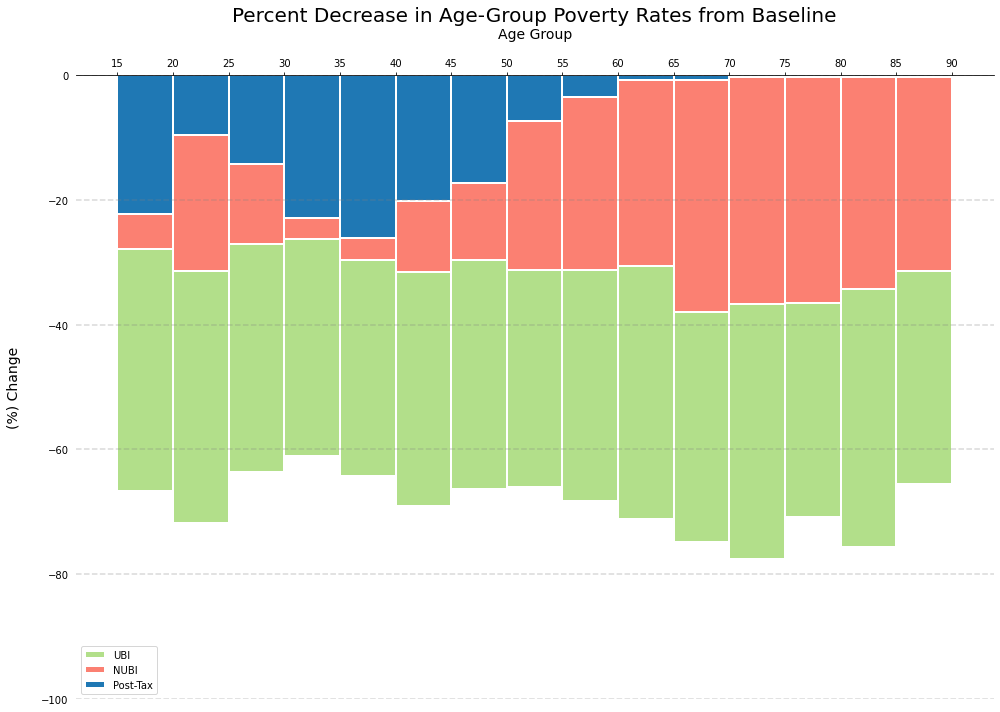

In [70]:
#plot % Change in Age Poverty Across Models: 
#labels = ['15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64', '65-69','70-74','75-79','80-84','85-90']

fig, ax = plt.subplots(figsize=(14, 10))

plt.bar(age_perc_change['AGE_GROUP'], age_perc_change['AGE_PERC_CHANGE_UBI'], align = 'edge', width = 1, edgecolor = "white", linewidth = 2, color = ('#b2df8a'), label = "UBI")
plt.bar(age_perc_change['AGE_GROUP'], age_perc_change['AGE_PERC_CHANGE_NUBI'], align = 'edge', width = 1, edgecolor = "white", linewidth = 2, color = ('#fb8072'), label = "NUBI")
plt.bar(age_perc_change['AGE_GROUP'], age_perc_change['AGE_PERC_CHANGE_TAX'], align = 'edge', width = 1, edgecolor = "white", linewidth = 2, color = ('#1f78b4'), label = "Post-Tax")

# Set title
ax.set_title("Percent Decrease in Age-Group Poverty Rates from Baseline", size=20)

#Format x-axis
ax.set_xticks(age_perc_change["AGE_GROUP"])
ax.set_xlabel("Age Group", labelpad=20, size=14) 
ax.tick_params(axis="both", which="both", bottom="off", top="off", left="off", right="off", labelleft="on")
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")


#ax.set_xlim(-100, 0)

# Draw horizontal axis lines
ax.set_ylim(-100, 0)
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.3, color='grey', zorder=1)
ax.set_ylabel("(%) Change", labelpad=20, size=14) 


# Despine
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(True)
ax.spines['left'].set_visible(False)

#removing frame 
plt.tick_params(axis='y', which='both', top=False, left = False, right = False)
plt.tick_params(axis='x', which='both', top=True)
plt.legend()
fig.tight_layout()

One can see from this plot that the UBI models both performed better at reducing elderly poverty in pre-tax income than the U.S. tax system. As discussed previously, a reason for this could be that the SSI and social security income are already accounted for in the pre-tax income of the elderly, thus undercounting the impact of the existing welfare system on the elderly. 